In [1]:
import os
from pathlib import Path
from typing import Dict
from tqdm import tqdm_notebook as tqdm
import chromadb
from sentence_transformers import SentenceTransformer, util

import pickle
from paper_tree import PaperTree

import torch
import numpy as np

### Load the paper tree

In [2]:
dir_paper_trees = "../data/paper_trees/"
filenames = list(filter(lambda str : (".pkl" in str[-4:]), os.listdir(dir_paper_trees)))

In [3]:
papers = {}
for filename in filenames:
    with open(dir_paper_trees + filename, "rb") as f:
        paper = pickle.load(f)
        papers[paper.title] = paper

In [4]:
def gather_abstracts(paper, abstracts, id=""):
    if paper.abstract is not None:
        abstracts[id] = paper.abstract
    for section in paper.sections:
        gather_abstracts(section, abstracts, f"{id} --> {section.title}")
    

abstracts = {}
for title, paper in papers.items():
    #gather_abstracts(paper, abstracts, paper.title)
    abstracts[title] = paper.abstract

RAG on the Abstracts

In [5]:
model = SentenceTransformer(
    "hkunlp/instructor-large",
    cache_folder = "/n/home10/jmcgreivy/beauty-in-stats/data/sentence-transformers-cache"
).to("cuda")

In [6]:
instruction = "Represent abstracts from particle physics papers for retrieval: "
abstract_embeddings = model.encode(list(abstracts.values()), prompt=instruction)

### Plot LHCb Abstract Embedding PCAs

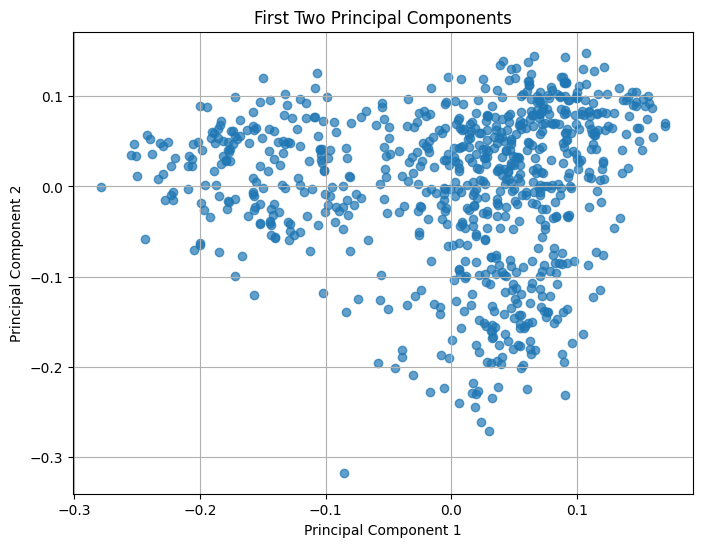

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(abstract_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.title("First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

### RAG

In [35]:
client = chromadb.EphemeralClient() 
lhcb_abstracts = client.get_or_create_collection(
        name="lhcb_abstracts",
        metadata={"hnsw:space": "cosine"}
)

all_documents = lhcb_abstracts.get()
if len(all_documents['ids']) > 0:
    lhcb_abstracts.delete(ids=all_documents['ids'])

lhcb_abstracts.add(
    embeddings = abstract_embeddings,
    documents = list(abstracts.values()),
    ids = list(abstracts.keys()),
)

query = "Did LHCb measure the CKM matrix element $|V_{ub}|$ using semimuonic decays?"
query_instruction = (
    "Represent user query to retrieve the most relevant particle physics publication: "
)
query_embedding = model.encode(query, prompt=query_instruction)

# Perform similarity search in the ChromaDB collection
ab_results = lhcb_abstracts.query(
    query_embeddings = [query_embedding],  # Use the query embedding
    n_results = 20  # Retrieve top 5 most relevant results
)

In [36]:
def build_chromadb_collection(corpus):
    instruction = "Represent abstracts from particle physics papers for retrieval: "
    embeddings = model.encode(list(corpus.values()), prompt=instruction)
    
    collection = client.get_or_create_collection(
        name="corpus_collection",
        metadata={"hnsw:space": "cosine"}
    )

    all_documents = collection.get()
    if len(all_documents['ids']) > 0:
        collection.delete(ids=all_documents['ids'])

    collection.add(
        embeddings = embeddings,
        documents = list(corpus.values()),
        ids = list(corpus.keys()),
    )

    return collection

In [41]:
results = ab_results
relevant_sections_pre = papers
relevant_sections_post = {}
relevant_abstracts = {}

In [45]:
for title in results["ids"][0]:
    paper = relevant_sections_pre[title]
    if len(paper.sections) == 0:
        id = title
        if section.abstract is not None:
            relevant_sections_post[id] = paper
            relevant_abstracts[id] = paper.abstract
        else:
            relevant_sections_post[id] = paper
            relevant_abstracts[id] = paper.text
    else:
        for section in paper.sections:
            id = f"{title} --> {section.title}"
            if section.abstract is not None:
                relevant_sections_post[id] = section
                relevant_abstracts[id] = section.abstract
            else:
                relevant_sections_post[id] = section
                relevant_abstracts[id] = section.text

collection = build_chromadb_collection(relevant_abstracts)

# Perform similarity search in the ChromaDB collection
results = collection.query(
    query_embeddings = [query_embedding],  # Use the query embedding
    n_results = 10  # Retrieve top 5 most relevant results
)
relevant_sections_pre = relevant_sections_post
relevant_sections_post = {}
relevant_abstracts = {}

TypeError: can only concatenate str (not "NoneType") to str

In [51]:
relevant_sections_pre['2001.03225.tex --> Headers'].text

'\\pdfoutput=1\n\n\n\\documentclass[12pt,a4paper]{article}\n\n\n\\usepackage{ifthen} \\newboolean{pdflatex}\n\\setboolean{pdflatex}{true} \\usepackage{multirow} \\newboolean{articletitles}\n\\setboolean{articletitles}{true} \n\n\\newboolean{uprightparticles}\n\\setboolean{uprightparticles}{false} \n\n\\newcommand{\\todo}[1]{\\textcolor{red}{#1}}\n\n\\def\\Vcb{\\ensuremath{\\lvert V_{\\cquark\\bquark}\\rvert}\\xspace}\n\\newcommand{\\etaEW}{\\ensuremath{\\eta_{\\rm EW}}\\xspace}\n\\newcommand{\\Fnorm}{\\ensuremath{h_{A_1}(1)}\\xspace}\n\\newcommand{\\Rone}{\\ensuremath{R_1(1)}\\xspace}\n\\newcommand{\\Rtwo}{\\ensuremath{R_2(1)}\\xspace}\n\\newcommand{\\Gnorm}{\\ensuremath{\\mathcal{G}(0)}\\xspace}\n\\newcommand{\\diff}{\\ensuremath{{\\rm d}}\\xspace}\n\\newcommand{\\ext}{\\aunit{(ext)}\\xspace}\n\n\\newcommand{\\BuorBd}{\\ensuremath{\\B^{+/0}}\\xspace}\n\\newcommand{\\BorBs}{\\ensuremath{\\B^{0}_{(\\squark)}}\\xspace}\n\\newcommand{\\DorDs}{\\ensuremath{\\D_{(\\squark)}}\\xspace}\n\\new

In [44]:
results['ids']

[['2012.05143.tex --> Chunk 49',
  '1509.00414.tex --> Summary',
  '2012.05143.tex --> Chunk 51',
  '2003.04831.tex --> Chunk 54',
  '1702.06490.tex --> Chunk 43',
  '1304.6173.tex --> Chunk 56',
  '1508.06087.tex --> Result',
  '2309.09728.tex --> Chunk 72',
  '1401.6932.tex --> Conclusions',
  '2309.09728.tex --> Chunk 51']]